# Analyse exploratoire du house_price_df sur les prix de maison à Ames dans l'Iowa

Le house_price_df fourni pour le projet regroupe, pour la ville d'Ames dans l'Iowa, un ensemble de 79 variables décrivant quasiment l'ensemble des aspects d'une maison.  
Pour une raison de compréhension des métriques l'ensemble des colonnes exprimées en feet seront converties en mètres suivant ces formules :  
- 1m = 1ft/3.2808  
- 1m² = 1ft² * 0.0929

In [219]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve, learning_curve, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.impute import KNNImputer

In [220]:
dataset = pd.read_csv('Data/train.csv')
house_price_df = dataset.copy(deep=True)
house_price_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


La colonne MSSubClass représente, sous forme d'entier, le type du logement :  
- 20	Maison 1 étage depuis 1946 de tous styles  
- 30	Maison 1 étage avant 1945 compris  
- 40    Maison 1 étages avec grenier fini de tous âges
- 45	Maison 1 étage + 1/2 étages non finie de tous âges
- 50	Maison 1 étage + 1/2 étages finie de tous âges
- 60	Maison 2 étages depuis 1946 de tous styles 
- 70	Maison 2 étages avant 1945 compris  
- 75	Maison 2 étages + 1/2 étage de tous âges
- 80	Maison Multi-level ou séparé 
- 85	Maison avec foyer séparé
- 90	Duplex tous styles et tous âges
- 120	Maison 1 étage PUD (Planned Unit Development) - 1946 à maintenant
- 150	Maison 1+1/2 étages PUD tous âges
- 160	Maison 2 étages PUD - 1946 à maintenant
- 180	Maison multi-level avec split ou sans split d'étages ou avec foyer splité PUD 
- 190	Maison mitoyenne - tous styles et tous âges

PUD : Plan d'urbanisation où l'ensemble des maison d'un même quartier sont contruites suivant le même plan architecturale.

Une maison 1 étage correspond à une maison plein pied pour nous français.
1er étage équivaut au rez-de-chaussée.

Le type de logement a une influence sur le prix car, la surface d'habitable est corrélée au type de logement.

MSZoning repésente le type de zone où ce trouve le logement :
- A     Agriculture
- C	    Commerciale
- FV	Floating Village Residential ??? (habitation sur flotante sur rivière ou bard de lac/rivière)
- I 	Industrielle
- RH	Résidentielle à haute densité
- RL	Résidentielle à faible densité
- RP	Résidentielle à faible densité avec Parc 
- RM	Résidentielle à moyenne densité

Colonne : 
- LotFrontage => Taille de route coonecté au terrain, en feet
- LotArea => Taille du terrain, en sqare feet
- YearBuilt => Date de construction d'origine
- YearRemodAdd => Date de travaux d'aménagement (même que la date de contruction si aménagement ou addition)
- MasVnrArea => Zone Façade extérieure en square feet
- BsmtFinSF1 => Aire du premier sous-sol en square feet
- BsmtFinSF2 => Aire du second sous-sol (s'il existe) en square feet
- BsmtUnfSF => Aire non finie du sous-sol en square feet
- TotalBsmtSF => aire totale du sous-sol en square feet
- 1stFlrSF => Aire du 1er étage(rez-de-chaussée en France) en square feet
- 2ndFlrSF => Aire du 2ème étage(1er étage en France) en square feet
- LowQualFinSF => Zone Finition basse qualité en sqaure feet
- GrLivArea => Zone habitable au dessus du sol en square feet
- BsmtFullBath => Nombre de salles de bain du sous-sol
- BsmtHalfBath => Nombre de toilettes du sous-sol
- FullBath => Nombre de salles de bain au-dessus du sol
- HalfBath => Nombre de toilettes au-dessus du sol
- Bedroom => Nombre de Chambres au-dessus du sol (n'inclus pas les chambres du sous-sol)
- Kitchen => Nombre de cuisines au-dessus du sol
- TotRmsAbvGrd => Nombre total de salles au-dessus du sol (n'inclus pas salle de bain et toilettes)
- Fireplaces => Nombre de cheminées
- GarageYrBlt => Année de construction du garage
- GarageCars => Taille du garage en nombre de voitures qu'il peut contenir
- GarageArea => Aire du garage en square feet
- WoodDeckSF => Aire d'une terrasse boisée en square feet
- OpenPorchSF => Aire du porch ouvert en square feet
- EnclosedPorch => Aire du porch fermé en square feet
- 3SsnPorch => Aire du porch 3 saisons en square feet
- ScreenPorch => Aire du porch à grillage en square feet
- PoolArea => Aire de la piscine en square feet
- MiscVal => Valeur en $ des fonctions diverses
- MoSold => Mois de la vente (MM)
- YrSold => Année de la vente (YYYY)

Les colonnes exprimées en feet ou square feet seront converties en mètre ou mètre carré

Street: Le type de route pour accéder au logement
- Grvl  Gravier	
- Pave	 Pavé
       	
Alley: Le type d'allée pour accéder au logement
- Grvl	 Gravier
- Pave	 Pavé
- NA 	 Pas d'allée
		
LotShape: Forme général du terrain
- Reg	Regulière	
- IR1	légèrement irrégulière
- IR2	Modéremment irrégulière
- IR3	Irrégulière

LandContour: PAspect plat du terrain
- Lvl	Quasiment plat
- Bnk	Montée rapide et significative pour accéder au logemement
- HLS	Pente montante et descendante autour du logement
- Low	Dépression


Utilities: Type de services disponible
- AllPub	toutes les services publiques (E = Electricité, G = Gaz ,W = Eau & S = Fosse septique)	
- NoSewr	Electricité, Gaz et Eau
- NoSeWa	Electricité et Eau
- ELO	    Electricité	
	
LotConfig: Configuration du logemement dans le quartier
- Inside	intérieur du quartier
- Corner	Coin du quartier
- CulDSac	Cul-de-sac
- FR2	    Début de quartier avec 2 côtés exposés
- FR3	    Début de quartier avec 3 côtés exposés
	
LandSlope: Pente du terrain
- Gtl	Pente douce
- Mod	pente modérée
- Sev	Pente aiguë

Neighborhood: Location du logement dans la ville d'Ames
- Blmngtn	Bloomington Heights
- Blueste	Bluestem
- BrDale	Briardale
- BrkSide	Brookside
- ClearCr	Clear Creek
- CollgCr	College Creek
- Crawfor	Crawford
- Edwards	Edwards
- Gilbert	Gilbert
- IDOTRR	Iowa DOT and Rail Road
- MeadowV	Meadow Village
- Mitchel	Mitchell
- Names	North Ames
- NoRidge	Northridge
- NPkVill	Northpark Villa
- NridgHt	Northridge Heights
- NWAmes	Northwest Ames
- OldTown	Old Town
- SWISU	South & West of Iowa State University
- Sawyer	Sawyer
- SawyerW	Sawyer West
- Somerst	Somerset
- StoneBr	Stone Brook
- Timber	Timberland
- Veenker	Veenker

Condition1: Proximité des lieux particuliers
- Artery	Adjacent à une artère routière
- Feedr	    Adjacent à une voie d'insertion	
- Norm	    Normal	
- RRNn	    A 200 feet du chemin de fer Nord-Sud
- RRAn	    Adjacnet au chemin de fer Nord-Sud
- PosN	    Près des sorties des Parc et autres zones forestières 
- PosA	    Adjacent aux sorties des Parc et autres zones forestières 
- RRNe	    A 200 feet du chemin de fer Est-Ouest
- RRAe	    Adjacent au chemin de fer Est-Ouest
	
Condition2: Proximité des lieux particuliers (si plus d'une présente)
- Artery	Adjacent à une artère routière
- Feedr	    Adjacent à une voie d'insertion	
- Norm	    Normal	
- RRNn	    A 200 feet du chemin de fer Nord-Sud
- RRAn	    Adjacnet au chemin de fer Nord-Sud
- PosN	    Près des sorties des Parc et autres zones forestières 
- PosA	    Adjacent aux sorties des Parc et autres zones forestières 
- RRNe	    A 200 feet du chemin de fer Est-Ouest
- RRAe	    Adjacent au chemin de fer Est-Ouest

BldgType: Type de logement
- 1Fam => Logement 1 famille	
- 2FmCon => Maison mitoyenne
- Duplx => Duplex
- TwnhsE => Maison de ville extrémité quatier 
- wnhsI => Maison de ville intérieure quatier
	
HouseStyle: Style de logement
- 1Story => 1 étage
- 1.5Fin => 1 + 1/2 étages : 2ème étage fini
- 1.5Unf => 1 + 1/2 étages : 2ème étage non fini
- 2Story => 2 étages
- 2.5Fin => 2 + 1/2 étages : 3ème étage fini
- 2.5Unf => 2 + 1/2 étages : 3ème étage non fini
- SFoyer => Foyer séparé
- SLvl => Étage divisé

OverallQual: Note globale pour les matériaux et finition du logement   
OverallCond: Note globale de la condition du logement 
- 10 => Very Excellent
- 9	=> Excellent
- 8	=> Very Good
- 7	=> Good
- 6	=> Above Average
- 5	=> Average
- 4	=> Below Average
- 3	=> Fair
- 2	=> Poor
- 1	=> Very Poor


RoofStyle: Type de toit
- Flat => Plat
- Gable	=> Gâble
- Gambrel => Grange
- Hip => toit en croupe
- Mansard => Mansarde
- Shed => toit en appentis
		
RoofMatl: matériau toit
- ClyTile => Tuile d'argile
- CompShg => Bitume
- Membran => Membrane
- Metal => Metal
- Roll => Rouleau d'asphalte
- Tar&Grv => Groudon et gravier
- WdShake => Bardeau finition brute
- WdShngl => Bardeau finition fine

Exterior1st: Recouvrement extérieur du logement  
Exterior2nd: Recouvrement extérieur du logement (si plus d'un matériau utilisé)
- AsbShng => Bardeau en amiante
- AsphShn => Bardeau en asphalte
- BrkComm => Brique standard
- BrkFace => Brick Face
- CBlock => Parpaing
- CemntBd => Panneau de béton
- HdBoard => Panneau fibre à haute densité
- ImStucc => Imitation Enduit Stucco
- MetalSd => Bardage métallique
- Other	=> Autre
- Plywood => Contre-plaqué
- PreCast => Béton préfabriqué
- Stone => Pierre
- Stucco => Enduit Stucco
- VinylSd => Revêtement en vinyle
- Wd Sdng => Revêtement en bois
- WdShing => Bardeau 

MasVnrType: Façade extérieure
- BrkCmn => Brique standard
- BrkFace => Brick Face
- CBlock => Parpaing
- None => Aucun
- Stone => Pierre  
  
Foundation: Type de foundation
- BrkTil => Brique et argile
- CBlock => Parpaing
- PConc	=> Béton coulé	
- Slab => Dalle
- Stone => Pierre
- Wood	=> Bois
	


ExterQual: Évaluation de la qualité des matériaux extérieures   
ExterCond: Évaluation de la condition des matériaux extérieures  
HeatingQC: Qualité et condition chauffage  
KitchenQual: Qualité de la cuisine   
- Ex => Excellent
- Gd => Good
- TA => Average/Typical
- Fa => Fair
- Po => Poor  
  
BsmtQual: Évaluation hauteur du sous-sol
- Ex => Excellent (+2.5m)	
- Gd => Good (2.2m - 2.5m)
- TA => Typical (2m - 2.2m)
- Fa => Fair (1.7m - 2m)
- Po => Poor (< 1.7m)
- NA => Pas de sous-sol  
  
BsmtCond: Évaluation de la condition du sous-sol
- Ex => Excellent
- Gd => Good
- TA => Typical - légère trace d'humidité
- Fa => Fair - humidité, fissure ou affaissement
- Po => Poor - Fissure ou affaissement importante ou moisissure
- NA => Pas de sous-sol

BsmtExposure: Refers to walkout or garden level walls
- Gd	Good Exposure
- Av	Average Exposure (split levels or foyers typically score average or above)	
- Mn	Mimimum Exposure
- No	No Exposure
- NA	No Basement  
  	
BsmtFinType1: Rating of basement finished area  
BsmtFinType2: Rating of basement finished area (if multiple types)  

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

In [221]:
house_price_df.shape

(1460, 81)

In [222]:
house_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

En utillisant le fontion info() pour le dataframe, on remarque que certaines colonnes ont un grand nombre de valeur nulle. Cependant, on sait que dans le csv et le descriptif des données, par exemple pour la colonne _Alley_, la valeur NA signifie l'absence d'allée.  
En comparant le dataframe et le csv, on remarque que l'ensemble des valeurs NA ont été transformé en valeur nulle (NaN). Le premier travail sera donc de transformer ces valeurs nulles en valeur NA.  

In [223]:
liste_colonne = [
    "Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
    "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"
]

for i in liste_colonne : 
    house_price_df[i].fillna('NA', inplace=True)

In [224]:
house_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

En remplaçant les valeurs NaN par NA comme voulue dans le csv dans les colonnes, il reste encore quelque colonnes où des valeurs vides sont présentes.  
  
Pour la colonne _LotFrontage_, il s'agit de valeur numérique on va donc remplacer les valeurs nulles par 0.  
Pour la colonne _MasVnrType_, on va transformer les valeurs nulles en none.  
Pour la colonne _MasVnrArea_, les valeurs nulles deviendront des 0.    
Pour la colonne _GarageYrBuilt_, on va remplacer les valeurs nulles on va utiliser le KNNinputer()

In [225]:
house_price_df_test = house_price_df.copy()

In [226]:
pd.DataFrame(house_price_df_test["GarageYrBlt"].value_counts()).to_string()

'        GarageYrBlt\n2005.0           65\n2006.0           59\n2004.0           53\n2003.0           50\n2007.0           49\n1977.0           35\n1998.0           31\n1999.0           30\n1976.0           29\n2008.0           29\n2000.0           27\n1968.0           26\n2002.0           26\n1950.0           24\n1993.0           22\n1958.0           21\n1966.0           21\n2009.0           21\n1962.0           21\n1965.0           21\n1970.0           20\n1996.0           20\n1957.0           20\n2001.0           20\n1978.0           19\n1954.0           19\n1960.0           19\n1997.0           19\n1974.0           18\n1964.0           18\n1994.0           18\n1995.0           18\n1959.0           17\n1956.0           16\n1963.0           16\n1990.0           16\n1980.0           15\n1979.0           15\n1969.0           15\n1967.0           15\n1973.0           14\n1988.0           14\n1920.0           14\n1972.0           14\n1940.0           14\n1992.0           13\n1961.0      

In [227]:
GarageYrBlt_imputer = KNNImputer(n_neighbors=4)
house_price_df_test['GarageYrBlt'] = GarageYrBlt_imputer.fit_transform(house_price_df_test[['GarageYrBlt']])

In [228]:
pd.DataFrame(house_price_df_test["GarageYrBlt"].value_counts()).to_string()

'             GarageYrBlt\n1978.506164           81\n2005.000000           65\n2006.000000           59\n2004.000000           53\n2003.000000           50\n2007.000000           49\n1977.000000           35\n1998.000000           31\n1999.000000           30\n1976.000000           29\n2008.000000           29\n2000.000000           27\n1968.000000           26\n2002.000000           26\n1950.000000           24\n1993.000000           22\n1958.000000           21\n1966.000000           21\n2009.000000           21\n1965.000000           21\n1962.000000           21\n2001.000000           20\n1970.000000           20\n1996.000000           20\n1957.000000           20\n1954.000000           19\n1997.000000           19\n1978.000000           19\n1960.000000           19\n1995.000000           18\n1994.000000           18\n1974.000000           18\n1964.000000           18\n1959.000000           17\n1990.000000           16\n1963.000000           16\n1956.000000           16\n1967.000000

In [229]:
house_price_df_test = house_price_df_test.astype({'GarageYrBlt' : int})
house_price_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [230]:
house_price_df_test["GarageYrBlt"].describe()

count    1460.000000
mean     1978.478082
std        23.994863
min      1900.000000
25%      1962.000000
50%      1978.000000
75%      2001.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

Avec le KNNImputer, on rempli les valeurs nulles par l'année 1978 or l'absence de valeur pour l'année de contruction d'un garage correspond à l'absence de garage.  
Ainsi, j'ai décidé de prendre pour référence l'année d'écriture de ce jupyter notebook et de créer une colonne avec l'âge du garage en année à l'année 2022 et donc lorsque la valeur de cet âge est de 0 cela signifie qu'il n'y a pas de garage.

In [231]:
house_price_df_test2 = house_price_df.copy()
house_price_df_test2.fillna(2022, inplace=True)
house_price_df_test2 = house_price_df_test2.astype({'GarageYrBlt': int})
house_price_df_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [232]:
house_price_df_test2['GarageAge'] = house_price_df_test2['GarageYrBlt'].apply(lambda x : 2022-x)
house_price_df_test2['GarageAge'].value_counts()

0      81
17     65
16     59
18     53
19     50
       ..
95      1
122     1
116     1
114     1
89      1
Name: GarageAge, Length: 98, dtype: int64

On a bien 81 fois la valeur 0, donc on a correctement remplie ces données manquantes.  
On supprimera la colonne _GarageYrBlt_ pour conserver seulement la colonne _GarageAge_

In [233]:
house_price_df['GarageYrBlt'].fillna(2022, inplace=True)
house_price_df = house_price_df.astype({'GarageYrBlt': int})
house_price_df['GarageYrBlt'] = house_price_df['GarageYrBlt'].apply(lambda x : 2022-x)
house_price_df.rename(columns={'GarageYrBlt': 'GarageAge'}, inplace=True)
house_price_df['GarageAge'].value_counts()

0      81
17     65
16     59
18     53
19     50
       ..
95      1
122     1
116     1
114     1
89      1
Name: GarageAge, Length: 98, dtype: int64

In [234]:
house_price_df['LotFrontage'].fillna(0, inplace=True)
house_price_df['MasVnrArea'].fillna(0, inplace=True)
house_price_df['MasVnrType'].fillna('none', inplace=True)
house_price_df = house_price_df.set_index('Id')
house_price_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [235]:
house_price_df['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

Dans la colonne _Electrical_, il y a une valeur nulle du coup on va la remplir avec la valeur la plus commune dans cette colonne soit _SBrkr_.

In [236]:
house_price_df['Electrical'].fillna('SBrkr', inplace=True)
house_price_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Il reste juste à convertir, pour des questions d'intrépations de résultats, les colonnes en feet et square feet en mètres et mètres carré

In [237]:
house_price_df['LotArea'].describe()

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

In [238]:
house_price_df['LotFrontage'].describe()

count    1460.000000
mean       57.623288
std        34.664304
min         0.000000
25%        42.000000
50%        63.000000
75%        79.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [239]:
colonne_conversion = [
    'LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
    'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
    'ScreenPorch', 'PoolArea'
]
for i in colonne_conversion :
    house_price_df[i] = house_price_df[i].apply(lambda x: x*0.0929)

house_price_df['LotFrontage'] = house_price_df['LotFrontage'].apply(lambda x:x/3.2808)

In [240]:
house_price_df['LotArea'].describe()

count     1460.000000
mean       977.013329
std        927.259512
min        120.770000
25%        701.720150
50%        880.552650
75%       1077.779350
max      19996.260500
Name: LotArea, dtype: float64

In [241]:
house_price_df['LotFrontage'].describe()

count    1460.000000
mean       17.563792
std        10.565808
min         0.000000
25%        12.801756
50%        19.202634
75%        24.079493
max        95.403560
Name: LotFrontage, dtype: float64

In [242]:
# dfCorr = house_price_df.corr(numeric_only=True)
# filteredDf = dfCorr[((dfCorr >= .2) | (dfCorr <= -.2)) & (dfCorr !=1.000)]
# plt.figure(figsize=(30,30))
# sns.heatmap(filteredDf, annot=True, cmap="Reds")
# plt.show()

Pour l'étude des données, on va tranformer les valeurs textuelles en valeur numériques afin d'avoir accès à la matrice de corrélation.  
En premier lieu, on travail sur les valeurs labelnales et binaires.

In [243]:
house_price_mc = house_price_df.copy()
label = LabelEncoder()

In [244]:
# print(house_price_mc['LotShape'].value_counts())
# print(house_price_mc.Street.value_counts())
# print(house_price_mc.Alley.value_counts())
# print(house_price_mc.Utilities.value_counts())
# print(house_price_mc.LandSlope.value_counts())

In [245]:
house_price_mc.LotShape = house_price_mc.LotShape.replace(['IR3', 'IR2', 'IR1', 'Reg'], [0, 1, 2, 3])
house_price_mc.Street = label.fit_transform(house_price_mc.Street)
house_price_mc.Alley = house_price_mc.Alley.replace(['NA', 'Grvl', 'Pave'], [0,1,2])
house_price_mc.Utilities = house_price_mc.Utilities.replace(['ELO', 'NoSeWa', 'NoSewr', 'AllPub'], [0,1,2,3])
house_price_mc.LandSlope = house_price_mc.LandSlope.replace(['Sev', 'Mod', 'Gtl'], [0,1,2])

In [246]:
# print(house_price_mc['LotShape'].value_counts())
# print(house_price_mc.Street.value_counts())
# print(house_price_mc.Alley.value_counts())

In [247]:
# print(house_price_mc.ExterQual.value_counts())
# print(house_price_mc.ExterCond.value_counts())
# print(house_price_mc.BsmtQual.value_counts())
# print(house_price_mc.BsmtCond.value_counts())
# print(house_price_mc.BsmtExposure.value_counts())

In [248]:
house_price_mc.ExterQual = house_price_mc.ExterQual.replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [0,1,2,3,4])
house_price_mc.ExterCond = house_price_mc.ExterCond.replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [0,1,2,3,4])
house_price_mc.BsmtQual = house_price_mc.BsmtQual.replace(['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], [0,1,2,3,4,5])
house_price_mc.BsmtCond = house_price_mc.BsmtCond.replace(['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], [0,1,2,3,4,5])
house_price_mc.BsmtExposure = house_price_mc.BsmtExposure.replace(['NA', 'No', 'Mn', 'Av', 'Gd'], [0,1,2,3,4])

In [249]:
# print(house_price_mc.ExterQual.value_counts())
# print(house_price_mc.ExterCond.value_counts())
# print(house_price_mc.BsmtQual.value_counts())
# print(house_price_mc.BsmtCond.value_counts())
# print(house_price_mc.BsmtExposure.value_counts())

In [250]:
# print(house_price_mc.BsmtFinType1.value_counts())
# print(house_price_mc.BsmtFinType2.value_counts())
# print(house_price_mc.HeatingQC.value_counts())
# print(house_price_mc.CentralAir.value_counts())
# print(house_price_mc.KitchenQual.value_counts())

In [251]:
house_price_mc.BsmtFinType1 = house_price_mc.BsmtFinType1.replace(['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], [0,1,2,3,4,5,6])
house_price_mc.BsmtFinType2 = house_price_mc.BsmtFinType2.replace(['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], [0,1,2,3,4,5,6])
house_price_mc.HeatingQC = house_price_mc.HeatingQC.replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [0,1,2,3,4])
house_price_mc.CentralAir = label.fit_transform(house_price_mc.CentralAir)
house_price_mc.KitchenQual = house_price_mc.KitchenQual.replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [0,1,2,3,4])

In [252]:
# print(house_price_mc.BsmtFinType1.value_counts())
# print(house_price_mc.BsmtFinType2.value_counts())
# print(house_price_mc.HeatingQC.value_counts())
# print(house_price_mc.CentralAir.value_counts())
# print(house_price_mc.KitchenQual.value_counts())

In [253]:
# print(house_price_mc.KitchenQual.value_counts())
# print(house_price_mc.FireplaceQu.value_counts())
# print(house_price_mc.GarageFinish.value_counts())
# print(house_price_mc.GarageQual.value_counts())
# print(house_price_mc.GarageCond.value_counts())

In [254]:
house_price_mc.KitchenQual = house_price_mc.KitchenQual.replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [0,1,2,3,4])
house_price_mc.FireplaceQu = house_price_mc.FireplaceQu.replace(['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], [0,1,2,3,4,5])
house_price_mc.GarageFinish = house_price_mc.GarageFinish.replace(['NA', 'Unf', 'RFn', 'Fin'], [0,1,2,3])
house_price_mc.GarageQual = house_price_mc.GarageQual.replace(['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], [0,1,2,3,4,5])
house_price_mc.GarageCond = house_price_mc.GarageCond.replace(['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], [0,1,2,3,4,5])

In [255]:
# print(house_price_mc.KitchenQual.value_counts())
# print(house_price_mc.FireplaceQu.value_counts())
# print(house_price_mc.GarageFinish.value_counts())
# print(house_price_mc.GarageQual.value_counts())
# print(house_price_mc.GarageCond.value_counts())

In [256]:
# print(house_price_mc.PavedDrive.value_counts())
# print(house_price_mc.PoolQC.value_counts())
# print(house_price_mc.Fence.value_counts())

In [257]:
house_price_mc.PavedDrive = label.fit_transform(house_price_mc.PavedDrive)
house_price_mc.PoolQC = house_price_mc.PoolQC.replace(['NA', 'Fa', 'TA', 'Gd', 'Ex'], [0,1,2,3,4])
house_price_mc.Fence = house_price_mc.Fence.replace(['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'], [0,1,2,3,4])

In [258]:
# print(house_price_mc.PavedDrive.value_counts())
# print(house_price_mc.PoolQC.value_counts())
# print(house_price_mc.Fence.value_counts())

On va commencer à travailler sur les catégories à valeurs nominales. On va utiliser un Frequency encoding.

In [259]:

list_nom_cat =[
    'MSZoning', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
    'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'Functional', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition'
]

for cat in list_nom_cat :
    # grouping by frequency
    fq = house_price_mc.groupby(cat).size()/len(house_price_mc)
    # fq = house_price_mc.groupby(cat).size()
    # mapping values to dataframe
    house_price_mc[cat] = house_price_mc[cat].map(fq)
    print(house_price_mc[cat].value_counts())

# fq.plot.bar(stacked=True)
# house_price_mc.head(10)

0.788356    1151
0.149315     218
0.044521      65
0.010959      16
0.006849      10
Name: MSZoning, dtype: int64
0.897945    1311
0.043151      63
0.034247      50
0.024658      36
Name: LandContour, dtype: int64
0.720548    1052
0.180137     263
0.064384      94
0.032192      47
0.002740       4
Name: LotConfig, dtype: int64
0.154110    225
0.102740    150
0.077397    113
0.068493    100
0.058904     86
0.054110     79
0.052740     77
0.050685     74
0.050000     73
0.040411     59
0.039726     58
0.034932     51
0.017123     50
0.033562     49
0.028082     41
0.026027     38
0.025342     37
0.011644     34
0.019178     28
0.010959     16
0.007534     11
0.006164      9
0.001370      2
Name: Neighborhood, dtype: int64
0.863014    1260
0.055479      81
0.032877      48
0.017808      26
0.013014      19
0.007534      11
0.005479       8
0.003425       5
0.001370       2
Name: Condition1, dtype: int64
0.989726    1445
0.001370       6
0.004110       6
0.000685       3
Name: Condition2, 

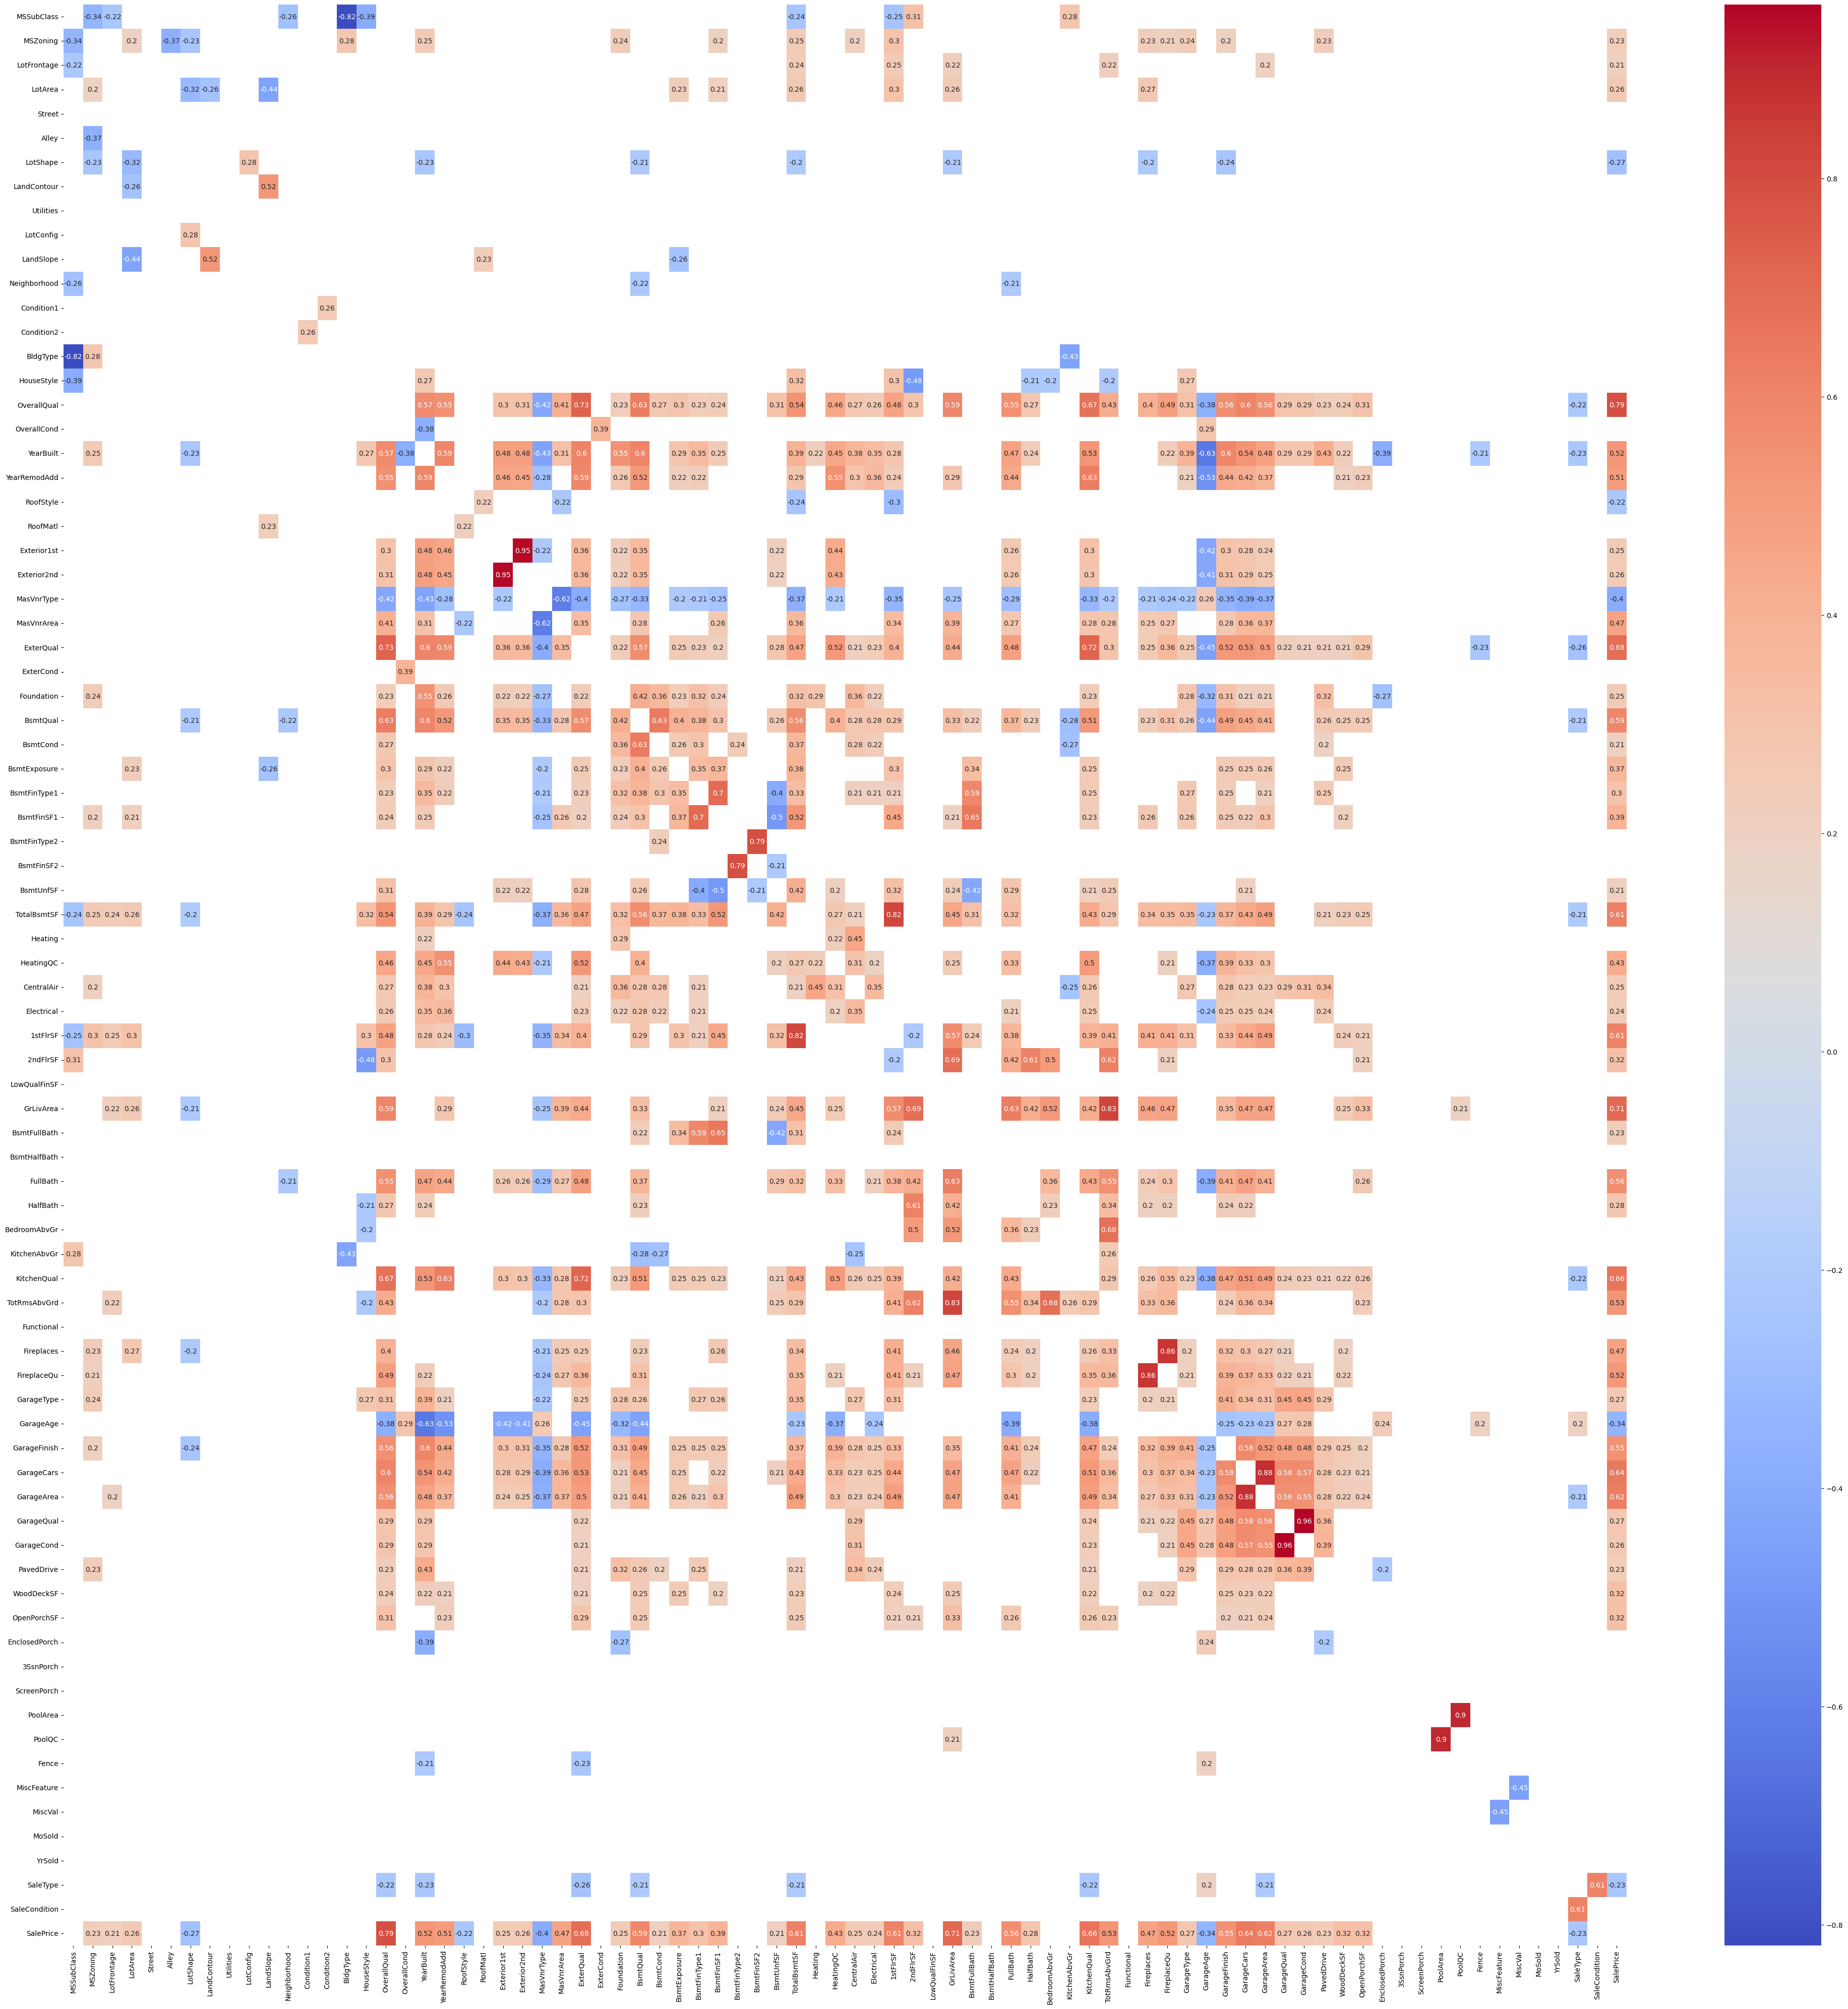

In [260]:
dfCorr = house_price_mc.corr(numeric_only=True)
filteredDf = dfCorr[((dfCorr >= .2) | (dfCorr <= -.2)) & (dfCorr !=1.000)]
plt.figure(figsize=(50,50))
sns.heatmap(filteredDf, annot=True, cmap="coolwarm")
plt.show()

Les colonnes interdépendantes :  
- PoolQC & PoolArea (négligeable)
- GarageCond & GarageQual
- GarageCars & GarageArea
- FirePlace & FireQual
- BsmtFinType & BsmtFinSF
- Exterior1st & Exterior2nd

Matrice de corrélation plus petite.

In [261]:
house_price_mc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   float64
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   float64
 4   Street         1460 non-null   int64  
 5   Alley          1460 non-null   int64  
 6   LotShape       1460 non-null   int64  
 7   LandContour    1460 non-null   float64
 8   Utilities      1460 non-null   int64  
 9   LotConfig      1460 non-null   float64
 10  LandSlope      1460 non-null   int64  
 11  Neighborhood   1460 non-null   float64
 12  Condition1     1460 non-null   float64
 13  Condition2     1460 non-null   float64
 14  BldgType       1460 non-null   float64
 15  HouseStyle     1460 non-null   float64
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [262]:
house_price_mc.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,0.788356,19.812241,785.0050,1,0,3,0.897945,3,0.720548,...,0.0,0,0,0.963014,0,2,2008,0.867808,0.820548,208500
2,20,0.788356,24.384297,891.8400,1,0,3,0.897945,3,0.032192,...,0.0,0,0,0.963014,0,5,2007,0.867808,0.820548,181500
3,60,0.788356,20.726652,1045.1250,1,0,2,0.897945,3,0.720548,...,0.0,0,0,0.963014,0,9,2008,0.867808,0.820548,223500
4,70,0.788356,18.288222,887.1950,1,0,2,0.897945,3,0.180137,...,0.0,0,0,0.963014,0,2,2006,0.867808,0.069178,140000
5,60,0.788356,25.603511,1324.7540,1,0,2,0.897945,3,0.032192,...,0.0,0,0,0.963014,0,12,2008,0.867808,0.820548,250000
6,50,0.788356,25.908315,1311.2835,1,0,2,0.897945,3,0.720548,...,0.0,0,3,0.033562,700,10,2009,0.867808,0.820548,143000
7,20,0.788356,22.860278,936.8036,1,0,3,0.897945,3,0.720548,...,0.0,0,0,0.963014,0,8,2007,0.867808,0.820548,307000
8,60,0.788356,0.000000,964.4878,1,0,2,0.897945,3,0.180137,...,0.0,0,0,0.033562,350,11,2009,0.867808,0.820548,200000
9,50,0.149315,15.544989,568.5480,1,0,3,0.897945,3,0.720548,...,0.0,0,0,0.963014,0,4,2008,0.867808,0.069178,129900


In [263]:
lot_zone1 = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour']
lot_zone2 = ['Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2']
lot_detail = ['BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd']
lot_contruc = ['RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond']
basement = ['Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
utilities = ['Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'Fireplaces', 'FireplaceQu', 'Functional']
taille = ['1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea']
rooms = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd']
garage = ['GarageType', 'GarageAge', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']
sold = ['MiscVal', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
outer = ['PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence']
price = ['SalePrice']

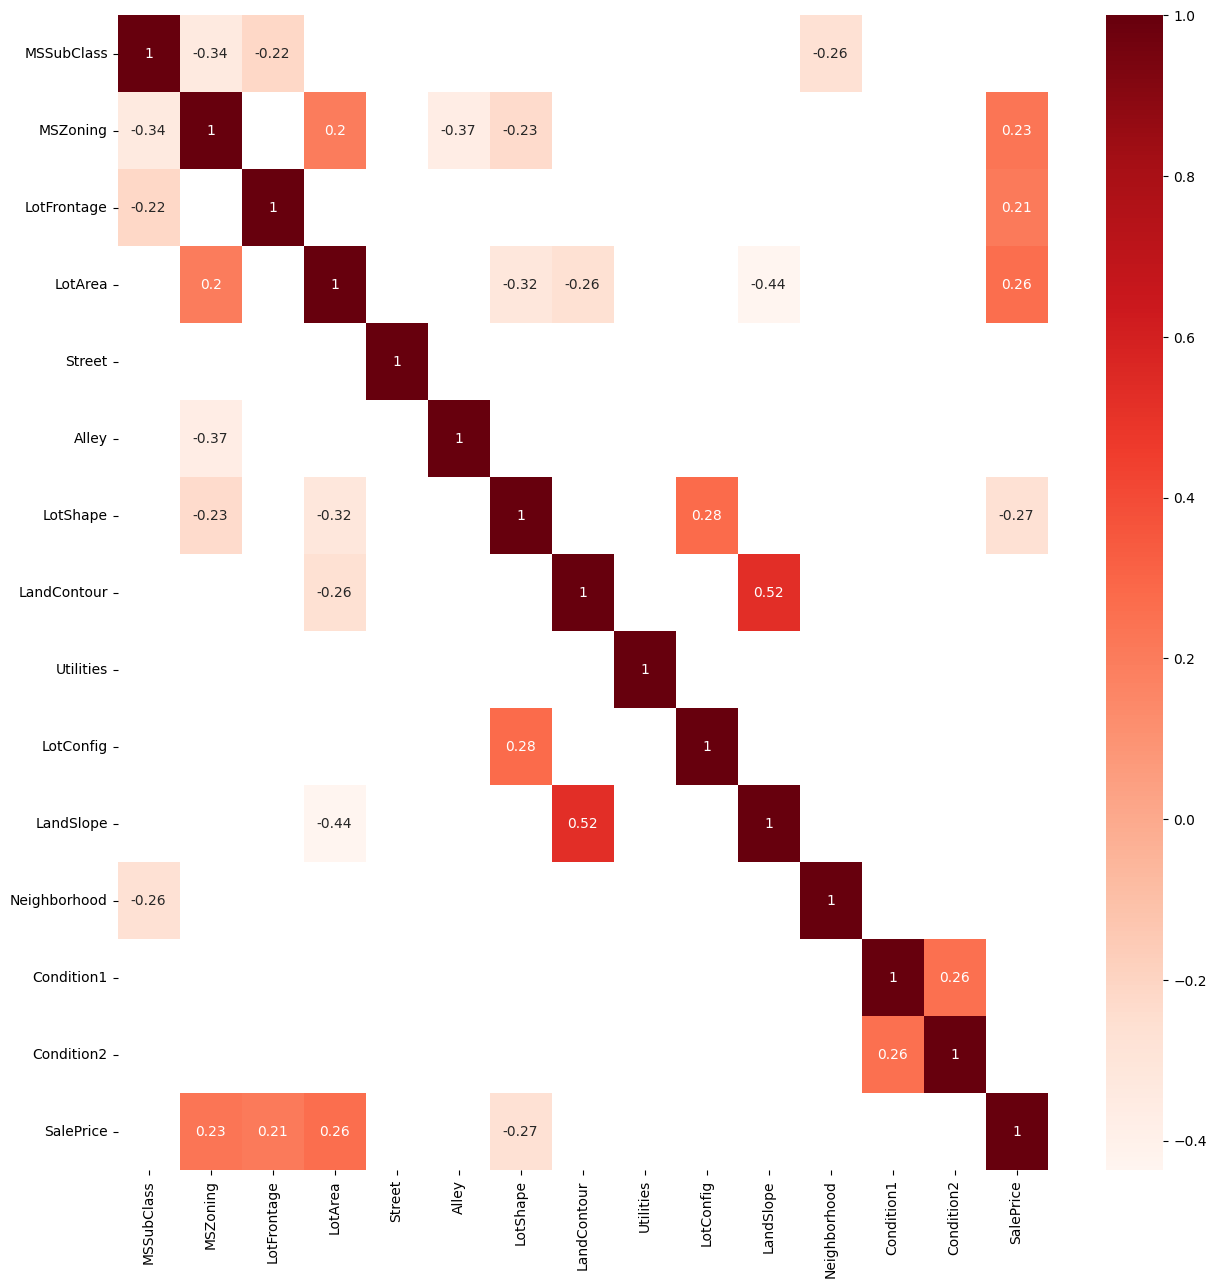

In [264]:
dfCorr = house_price_mc.loc[:,lot_zone1+lot_zone2+price].corr(numeric_only=True)
# filteredDf = dfCorr[((dfCorr >= .2) | (dfCorr <= -.2)) & (dfCorr !=1.000)]
filteredDf = dfCorr[((dfCorr >= .2) | (dfCorr <= -.2))]
plt.figure(figsize=(15,15))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
# sns.heatmap(dfCorr, annot=True, cmap="coolwarm")
plt.show()

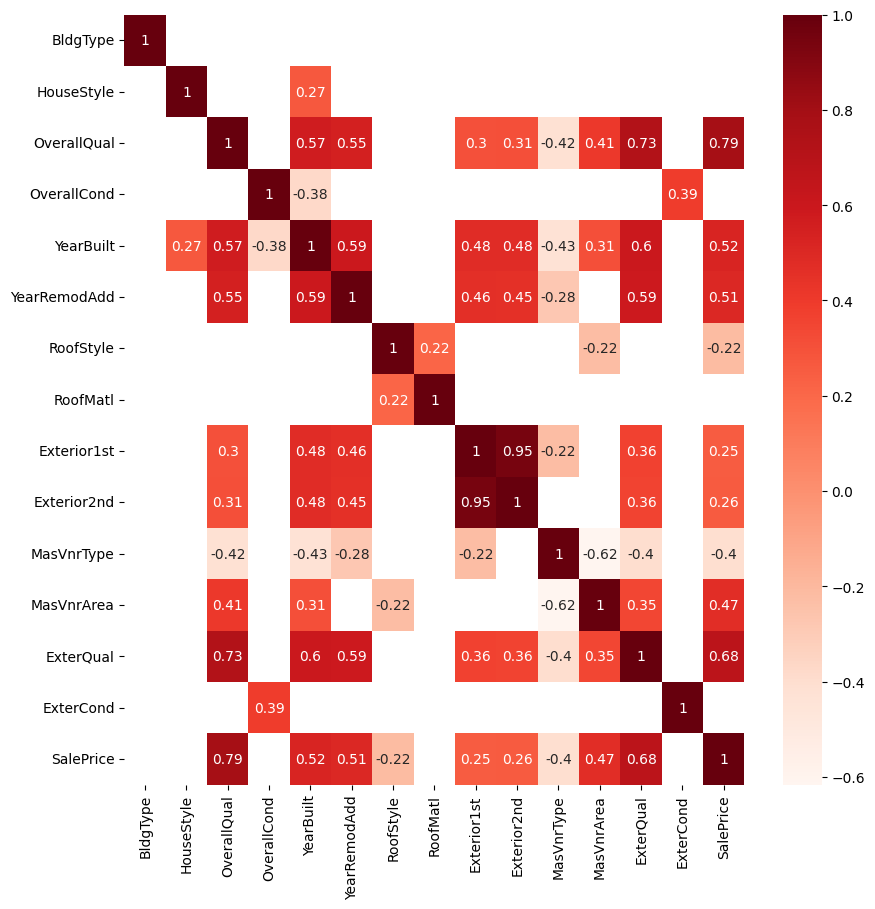

In [265]:
dfCorr = house_price_mc.loc[:,lot_detail+lot_contruc+price].corr(numeric_only=True)
# filteredDf = dfCorr[((dfCorr >= .2) | (dfCorr <= -.2)) & (dfCorr !=1.000)]
filteredDf = dfCorr[((dfCorr >= .2) | (dfCorr <= -.2))]
plt.figure(figsize=(10,10))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
plt.show()

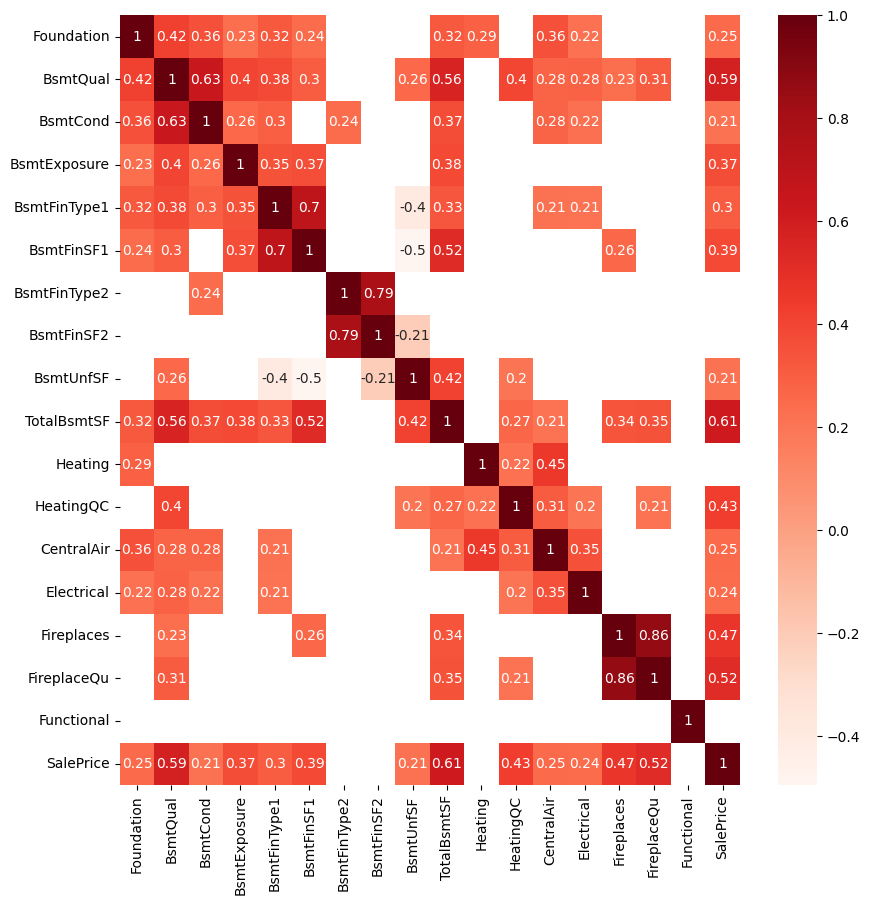

In [266]:
dfCorr = house_price_mc.loc[:,basement+utilities+price].corr(numeric_only=True)
# filteredDf = dfCorr[((dfCorr >= .2) | (dfCorr <= -.2)) & (dfCorr !=1.000)]
filteredDf = dfCorr[((dfCorr >= .2) | (dfCorr <= -.2))]
plt.figure(figsize=(10,10))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
plt.show()

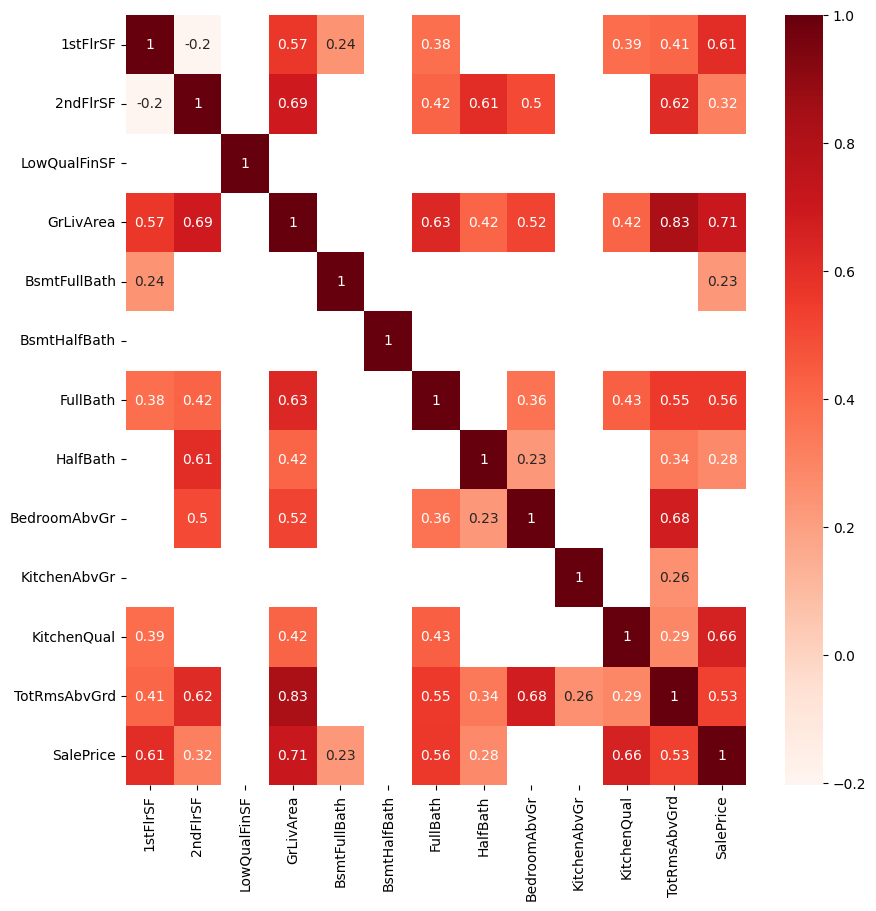

In [267]:
dfCorr = house_price_mc.loc[:,taille+rooms+price].corr(numeric_only=True)
# filteredDf = dfCorr[((dfCorr >= .2) | (dfCorr <= -.2)) & (dfCorr !=1.000)]
filteredDf = dfCorr[((dfCorr >= .2) | (dfCorr <= -.2))]
plt.figure(figsize=(10,10))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
plt.show()

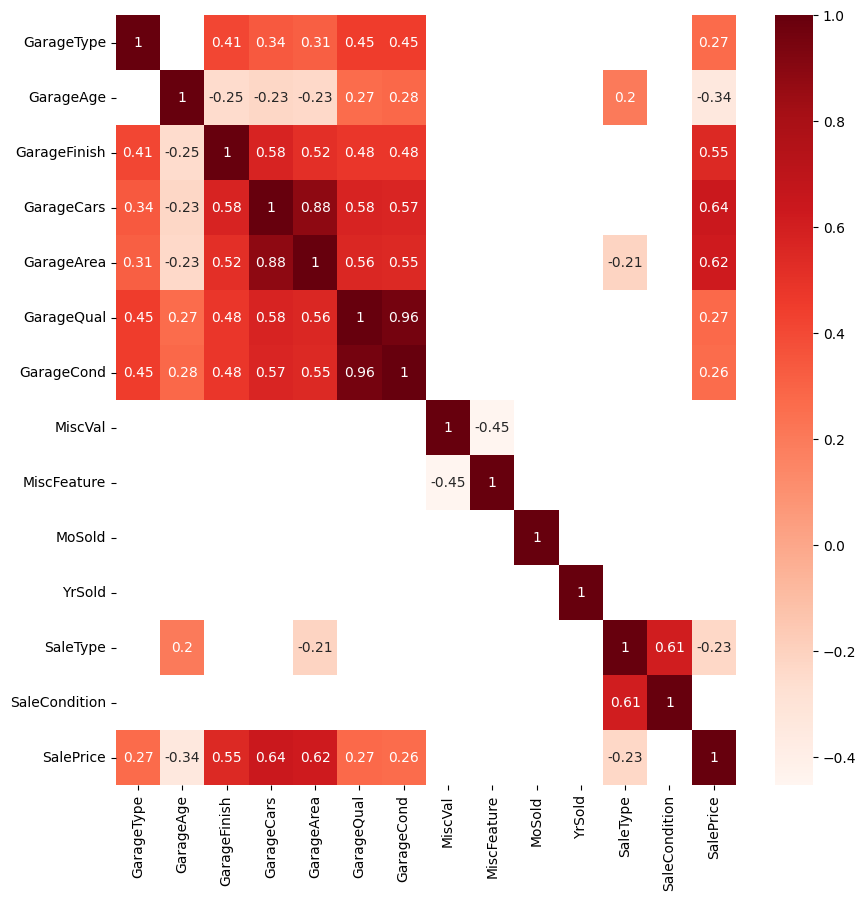

In [268]:
dfCorr = house_price_mc.loc[:,garage+sold+price].corr(numeric_only=True)
# filteredDf = dfCorr[((dfCorr >= .2) | (dfCorr <= -.2)) & (dfCorr !=1.000)]
filteredDf = dfCorr[((dfCorr >= .2) | (dfCorr <= -.2))]
plt.figure(figsize=(10,10))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
plt.show()

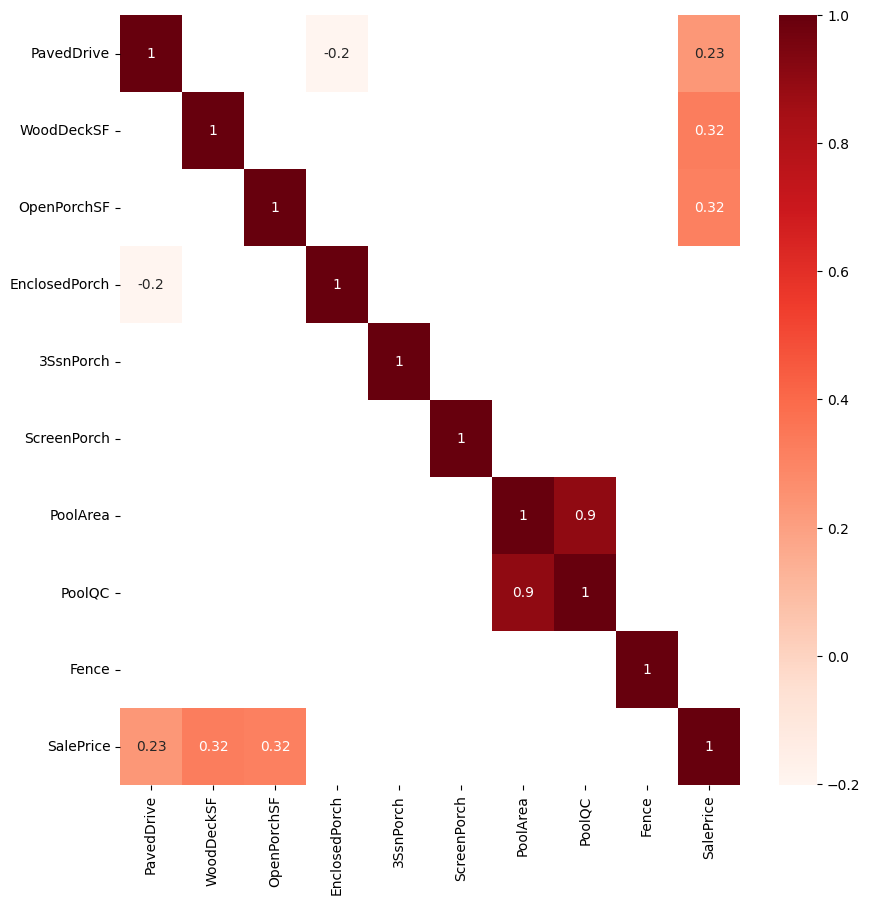

In [269]:
dfCorr = house_price_mc.loc[:,outer+price].corr(numeric_only=True)
# filteredDf = dfCorr[((dfCorr >= .2) | (dfCorr <= -.2)) & (dfCorr !=1.000)]
filteredDf = dfCorr[((dfCorr >= .2) | (dfCorr <= -.2))]
plt.figure(figsize=(10,10))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
plt.show()

Pour la mise en place des pipelines j'utiliserai plusieurs dataframe différents.  
  
Le premier Dataframe sera celui qui contient toutes les catégories et on regardera le résultat.  
  
Le second Dataframe ne contiendra que les catégories dont la magnitude est supérieur à 0.2 ou inférieur à -0.2. (Attention j'ai encodé les valeurs nominales avec leur fréquence d'appartion afin d'avoir une matrice de corrélation qui contient toutes les catégories)  
  
Dans la suite de notebook, je vais explorer certaines catégories qui on une influence sur le prix négligeable mais qui selon moi devrait avoir une influence sur le prix.

In [270]:
# pd.set_option('display.max_rows', None)
# house_price_mc.describe().T


In [271]:
# pd.reset_option('display.max_rows')

In [272]:
house_price_courbe = house_price_df.copy()

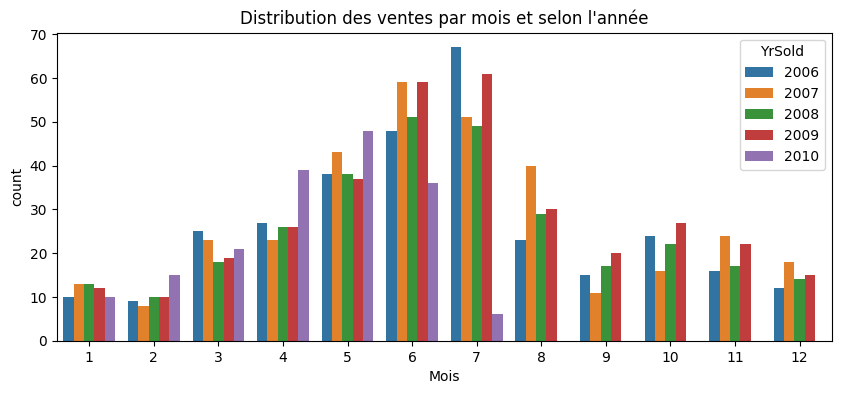

In [273]:
# Figure size
plt.figure(figsize=(10,4))
# Histogram
sns.countplot(data=house_price_courbe, x='MoSold', hue='YrSold')
plt.title("Distribution des ventes par mois et selon l'année")
plt.xlabel('Mois')
plt.show()

<Figure size 1000x400 with 0 Axes>

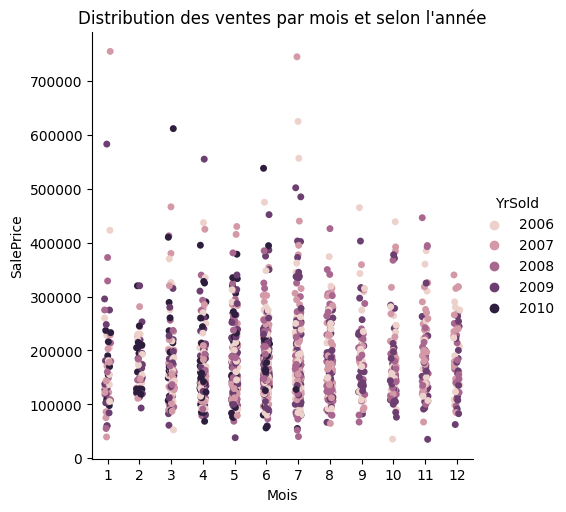

In [274]:
# Figure size
plt.figure(figsize=(10,4))
# Histogram
sns.catplot(data=house_price_courbe, x='MoSold', y='SalePrice', hue='YrSold')
plt.title("Distribution des ventes par mois et selon l'année")
plt.xlabel('Mois')
plt.show()

le mois n'a pas d'influence sur le prix de vente cependant, il influence le nombre de vente et il serait intéressant de transformer le mois en saison. 

<Figure size 1000x400 with 0 Axes>

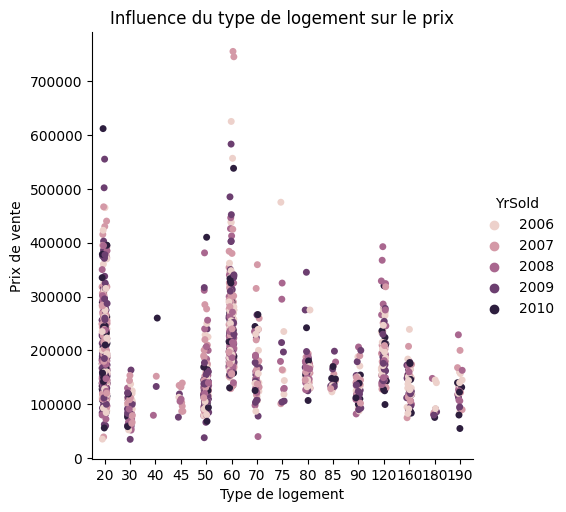

In [275]:
# Figure size
plt.figure(figsize=(10,4))
# Histogram
sns.catplot(data=house_price_courbe, x='MSSubClass', y='SalePrice', hue='YrSold')
plt.title("Influence du type de logement sur le prix")
plt.xlabel('Type de logement')
plt.ylabel('Prix de vente')
plt.show()

<Figure size 1000x400 with 0 Axes>

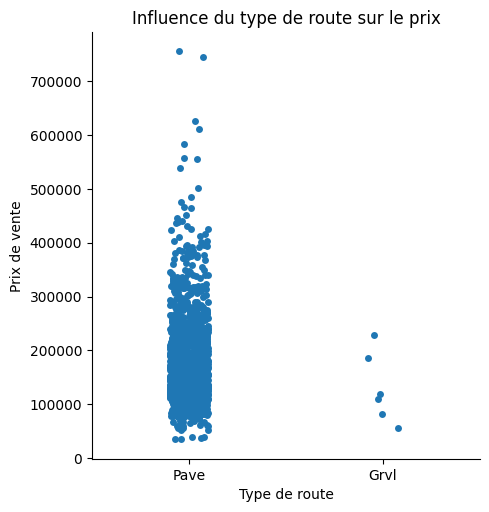

In [276]:
# Figure size
plt.figure(figsize=(10,4))
# Histogram
sns.catplot(data=house_price_courbe, x='Street', y='SalePrice')
plt.title("Influence du type de route sur le prix")
plt.xlabel('Type de route')
plt.ylabel('Prix de vente')
plt.show()

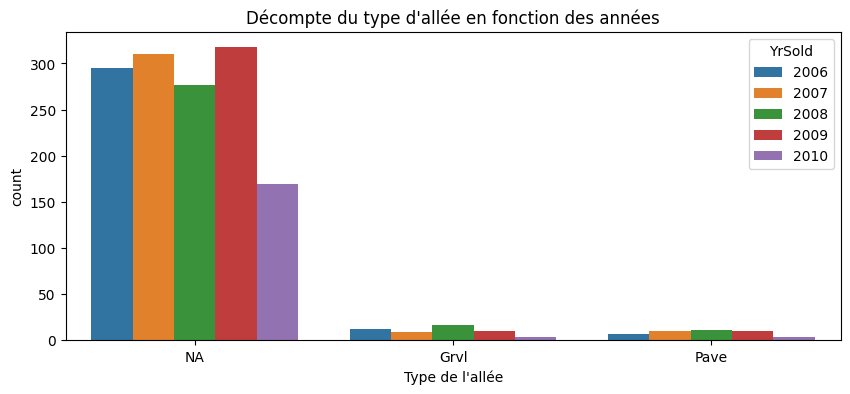

In [277]:
# Figure size
plt.figure(figsize=(10,4))
# Histogram
sns.countplot(data=house_price_courbe, x='Alley', hue='YrSold')
plt.title("Décompte du type d'allée en fonction des années")
plt.xlabel('Type de l\'allée')
plt.show()

Pour les colonnes _Alley_ et _Street_ on peut observer que la distribution des données est disproportionné et cela explique la magnitude négligeable selon mes critères.

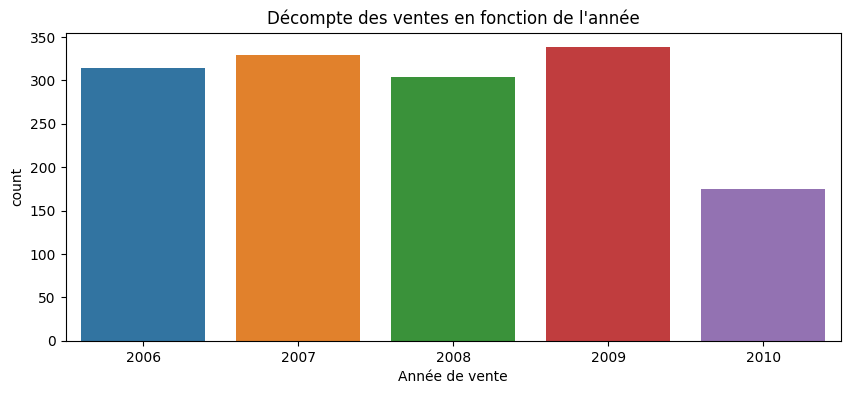

In [278]:
# Figure size
plt.figure(figsize=(10,4))
# Histogram
sns.countplot(data=house_price_courbe, x='YrSold')
plt.title("Décompte des ventes en fonction de l'année")
plt.xlabel('Année de vente')
plt.show()

<Figure size 1000x400 with 0 Axes>

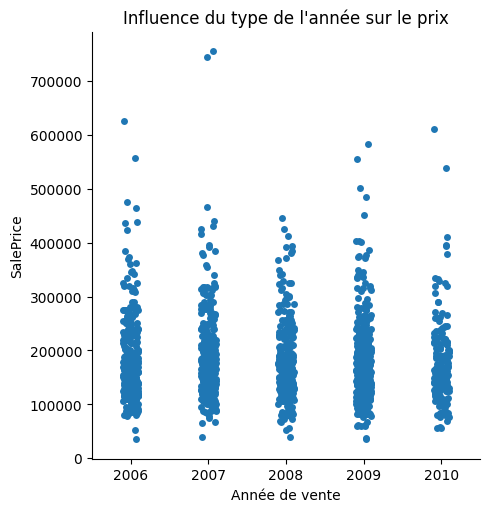

In [279]:
# Figure size
plt.figure(figsize=(10,4))
# Histogram
sns.catplot(data=house_price_courbe, x='YrSold', y='SalePrice')
plt.title("Influence du type de l'année sur le prix")
plt.xlabel('Année de vente')
plt.show()

<Figure size 1000x400 with 0 Axes>

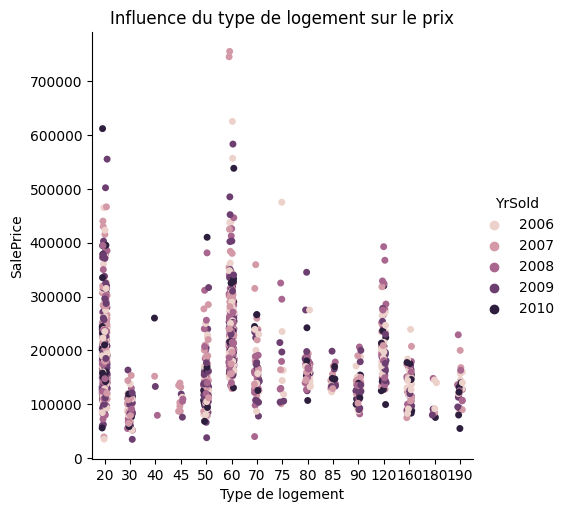

In [280]:
plt.figure(figsize=(10,4))
# Histogram
sns.catplot(data=house_price_courbe, hue='YrSold', x='MSSubClass', y='SalePrice')
plt.title("Influence du type de logement sur le prix")
plt.xlabel('Type de logement')
plt.show()